# Creating a protein expression atlas for the cell line data from PaxDB

In [1]:
import glob
import pandas as pd
import numpy as np
import mysql.connector

In [2]:
conn = mysql.connector.connect(user='root', password='password', host='127.0.0.1', port='3306',
                               database='expression_atlas_cells')
mycursor = conn.cursor(buffered=True)

# check the connection
if conn.is_connected():
    print("connection succesfull")
else:
    print("no connection")

connection succesfull


In [3]:
location = "/home/compomics/Sam/git/python/master_thesis/PaxDB/9606/9606"
df = pd.DataFrame(columns=["project_id", "internal_id", "string_external_id", "abundance", "raw_spectral_count"])
meta = {"project_id": [], "cell_line": [], "lab": []}

for file_location in glob.glob(location + "/*"):
    file = open(file_location, mode = "r")
    content = file.readlines()
    content = [x[:-1] for x in content]
    metadata = [x[1:] for x in content if x.startswith("#")]
    data = [x.split("\t") for x in content if not x.startswith("#")]
    cell_info = metadata[1]
    project_id = metadata[0].split()[-1]
    lab = cell_info.split()[-1]
    

    if ("Cell line" in cell_info) and ("(Integrated)" not in cell_info) and metadata[6] == "integrated: false":

        column_names = ["project_id"] + metadata[-1].split("\t")
        print("{}:\t{}".format(project_id, cell_info))
        
        pd_dict = {}
        for i in range(len(column_names)):
            
            pd_dict[column_names[i]] = []
            
            for row in data:
                if i == 0:
                    pd_dict["project_id"] += [project_id]
                else:
                    pd_dict[column_names[i]] +=  [row[i-1]]
        
        #print(pd.DataFrame(data = pd_dict).head())

        df = pd.concat([df, pd.DataFrame(data = pd_dict)], ignore_index = True, sort = False)
        meta["project_id"] += [project_id]
        meta["cell_line"] += [cell_info.split()[5]]
        meta["lab"] += [lab]
   

1189814538:	name: H.sapiens - Cell line, A460, SC (Balbin,nat_commun,2013)
2978442565:	name: H.sapiens - Cell line, H441, SC (Balbin,nat_commun,2013)
3192215036:	name: H.sapiens - Cell line, Es h9 (Phanstiel,nat_methods,2011)
292079461:	name: H.sapiens - Cell line, Huh7, SC (Pando-robles,j_proteomics,2014)
2072474002:	name: H.sapiens - Cell line, Cd8, SC (Kim,nature,2014)
931479677:	name: H.sapiens - Cell line, U2os (Beck,msb,2011)
3715944899:	name: H.sapiens - Cell line, Hek293, SC (Geiger,mcp,2012)
3939486675:	name: H.sapiens - Cell line, Pancreatic metastatic, SC (Kim,mcp,2014)
2141675680:	name: H.sapiens - Cell line, Hct116 (Koch,proteomics,2014)
3680206051:	name: H.sapiens - Cell line, Hela, SC (Geiger,mcp,2012)
1648883758:	name: H.sapiens - Cell line, Hela (Geiger,mcp,2012)
951997405:	name: H.sapiens - Cell line, Df4.7 (Phanstiel,nat_methods,2011)
3419065623:	name: H.sapiens - Cell line, Es 14 (Phanstiel,nat_methods,2011)
1377318544:	name: H.sapiens - Cell line, U251mg (Lundberg,

In [4]:
cell_annot = pd.read_csv("cell_annot.txt", sep = " ")

In [5]:
meta = pd.DataFrame(data= meta)
meta["cell_line"] = meta["cell_line"].apply(lambda x: x[:-1] if x[-1] == ',' else x)

df["string_external_id"] = df["string_external_id"].apply(lambda x: x[5:])

In [6]:
cell_annot = pd.read_csv("cell_annot.txt", sep = " ")
query = "SELECT cell_line, disease, tissue_type, treatment, sub_cell FROM cell"
db_df = pd.read_sql(query, conn)

def edit_cell_info(value):
    '''returns cell_line, disease, tissue_type'''
    
    if value[-1] == ',':
        value = value[:-1]

    #print(value,cell_annot[cell_annot.old_cell == value].new_name.values)
    value = cell_annot[cell_annot.old_cell == value].new_name.values[0]

    if value in db_df.cell_line.unique():
        info = db_df[db_df["cell_line"] == value][["disease", "tissue_type"]].drop_duplicates().values[0]
    
        return value, info[0], info[1]
    
    else:
        info = cell_annot[cell_annot.new_name == value][["disease", "tissue_type"]].drop_duplicates().values[0]
        return value, info[0], info[1]

In [7]:
meta["disease"] = '/'
meta["tissue_type"] = '/'
visited = []

for index, row in meta.iterrows():
    cell = row["cell_line"]
    if cell not in visited:
        new_cell, disease, tissue_type = edit_cell_info(cell)
        visited.append(new_cell)
        meta.loc[meta.cell_line == cell, ["cell_line", "disease", "tissue_type"]] = (new_cell, disease, tissue_type)

In [8]:
meta.tail()

,project_id,cell_line,lab,disease,tissue_type
52,3247844811,GaMG,"(Geiger,mcp,2012)",glioblastoma,brain
53,1439046864,A-431,"(Lundberg,msb,2010)",squamous_cell_carcinoma,skin
54,1367436943,LNCaP,"(Geiger,mcp,2012)",carcinoma,prostate
55,1450716477,SK-LU-1,"(Balbin,nat_commun,2013)",adenocarcinoma,lung
56,1933771905,U2OS,"(Lundberg,msb,2010)",osteosarcoma,bone


In [9]:
print(df.head())
meta.head()

   project_id internal_id string_external_id abundance raw_spectral_count
0  1189814538     4433451    ENSP00000229239     10954                705
1  1189814538     4433634    ENSP00000234590      7993                793
2  1189814538     4435133    ENSP00000262746      7295                480
3  1189814538     4436586    ENSP00000284440      6513                212
4  1189814538     4445814    ENSP00000373620      5507                710


,project_id,cell_line,lab,disease,tissue_type
0,1189814538,NCI-H460,"(Balbin,nat_commun,2013)",carcinoma,lung
1,2978442565,NCI-H441,"(Balbin,nat_commun,2013)",papillary_adenocarcinoma,lung
2,3192215036,ES,"(Phanstiel,nat_methods,2011)",/,/
3,292079461,Huh-7,"(Pando-robles,j_proteomics,2014)",hepatocellular_carcinoma,liver
4,2072474002,CD8,"(Kim,nature,2014)",/,blood


In [77]:
mapping = pd.read_csv("paxdb-uniprot-links-v4.2.tsv", sep = "\t", names = ["ENSP", "Uniprot"])
mapping = mapping[mapping.ENSP.apply(lambda x: True if x.startswith('9606') else False)]
mapping["ENSP"] = mapping.ENSP.apply(lambda x: x[5:])

In [192]:
mapping.head()

,ENSP,Uniprot
258546,ENSP00000000233,ARF5_HUMAN
258547,ENSP00000000412,MPRD_HUMAN
258548,ENSP00000001008,FKBP4_HUMAN
258549,ENSP00000001146,CP26B_HUMAN
258550,ENSP00000002125,NDUF7_HUMAN


In [195]:
f= open('uniprots.csv', "a")
for prot in mapping.Uniprot.unique().tolist():
    f.write(f"{prot},")

In [23]:
df.to_csv("parsed_PaxDB.csv", sep = "\t", index = False, na_rep=np.nan)

In [24]:
df = pd.read_csv("parsed_PaxDB.csv", sep = "\t")

In [20]:
df.groupby(["cell_line", "project_id"]).count()

internal_id  string_external_id  abundance  \
cell_line  project_id                                               
A431       1439046864         5304                5304       5304   
A460       1189814538         9672                9672       9672   
A549       878737823          9991                9991       9991   
           2538310174         3923                3923       3923   
           3312331274         9197                9197       9197   
Cd4        2689127103         7685                7685       7685   
Cd8        2072474002        11016               11016      11016   
Df19.11    2413264794         5609                5609       5609   
Df19.7     741679015          5610                5610       5610   
Df4.7      951997405          5609                5609       5609   
Df6.9      606872319          5611                5611       5611   
Es         2368295936         5611                5611       5611   
           3192215036         5610                5610       5610   
           3419065623         5599                5599       5599   
           3423318860         5610                5610       5610   
Gamg       3247844811         4086                4086       4086   
           4023575820         9991                9991       9991   
H1155      214261502         11094               11094      11094   
H1734      1699364461         5616                5616       5616   
H1792      2702723926         9104                9104       9104   
H2009      3299291630         5263                5263       5263   
H2122      1856553797         7180                7180       7180   
H23        3320206519         9058                9058       9058   
H358       4263836592         9672                9672       9672   
H441       2978442565         9971                9971       9971   
H727       928179904          7224                7224       7224   
Hct116     2141675680          904                 904        904   
Hek293     1717546768         9991                9991       9991   
           3715944899         4293                4293       4293   
Hela       261204445          3851                3851       3851   
           1603518140         8807                8807       8807   
           1648883758         9991                9991       9991   
           2374183461         7964                7964       7964   
           2499785856         7964                7964       7964   
           3680206051         3924                3924       3924   
Hepg2      1174466423         3530                3530       3530   
           4012390276         9991                9991       9991   
Huh7       292079461          1614                1614       1614   
Jurkat     496134848          3959                3959       3959   
           1349617245         9991                9991       9991   
K562       78171110           3337                3337       3337   
           3816746548         9991                9991       9991   
Lncap      1367436943         3941                3941       3941   
           2209482342         9991                9991       9991   
Mcf7       2007622231         4006                4006       4006   
           4257247611         9991                9991       9991   
Nk         1493102864         8874                8874       8874   
Pancreatic 3939486675         6171                6171       6171   
Rko        1003946721         3405                3405       3405   
           3395876293         9991                9991       9991   
Sklu1      1450716477         6990                6990       6990   
U251mg     1377318544         5295                5295       5295   
U2os       183123173          9991                9991       9991   
           274294083          4023                4023       4023   
           931479677          7094                7094       7094   
           1933771905         5302                5302       5302   
Vitreous   3074433814

In [9]:
test = pd.pivot(df, index = "project_id", columns = "string_external_id", values = "abundance")
test.fillna(0, inplace = True)
test = test.astype(float)
test.head()

string_external_id,ENSP00000000233,ENSP00000000412,ENSP00000001008,ENSP00000001146,ENSP00000002125,ENSP00000002165,ENSP00000002596,ENSP00000002829,ENSP00000003084,ENSP00000003100,...,ENSP00000485644,ENSP00000485645,ENSP00000485656,ENSP00000485659,ENSP00000485663,ENSP00000485664,ENSP00000485668,ENSP00000485672,ENSP00000485675,ENSP00000485678
project_id,,,,,,,,,,,,,,,,,,,,,
1003946721,363.0,48.00,1023.0,0.00,3.93,11.70,0.0,0.125,0.00,0.00,...,0.0,0.0,0.00,0.00,196.0,0.0,0.0,0.0,0.0,0.0
1174466423,67.8,7.19,564.0,0.00,7.12,6.21,0.0,0.023,0.00,7.08,...,0.0,0.0,0.00,0.00,135.0,0.0,0.0,0.0,0.0,0.0
1189814538,160.0,71.60,267.0,6.97,15.60,0.00,0.0,0.000,7.03,7.90,...,0.0,0.0,3.48,3.45,177.0,0.0,0.0,0.0,100.0,39.8
1349617245,198.0,136.00,223.0,0.00,103.00,0.00,0.0,0.000,0.00,42.90,...,0.0,0.0,0.00,40.50,209.0,0.0,0.0,0.0,0.0,0.0
1367436943,119.0,6.36,1241.0,0.00,1.26,2.47,0.0,0.000,0.00,3.60,...,0.0,0.0,0.00,0.00,266.0,0.0,0.0,0.0,0.0,0.0


In [10]:
(test == 0).sum(axis = 1)

project_id
1003946721    14901
1174466423    14776
1189814538     8634
1349617245    11017
1367436943    14365
1377318544    13115
1439046864    13068
1450716477    11316
1493102864     9432
1603518140     9607
1648883758    11038
1699364461    12690
1717546768    10360
183123173     10804
1856553797    11126
1933771905    13076
2007622231    14373
2072474002     7293
2141675680    17404
214261502      7212
2209482342    11172
2368295936    14333
2374183461    10345
2413264794    14335
2499785856    10342
2538310174    14383
261204445     14455
2689127103    10621
2702723926     9202
274294083     14283
292079461     16692
2978442565     8335
3074433814    17473
3192215036    14334
3247844811    14220
3299291630    13043
3312331274     9109
3320206519     9248
3395876293    11431
3419065623    14345
3423318860    14334
3680206051    14382
3715944899    14013
3816746548    11345
3939486675    12135
4012390276    11615
4023575820    10563
4257247611    11011
4263836592     8634
496134848

In [11]:
scaled = test.apply(lambda x: (x - x.mean())/x.std(), axis = 1)

In [51]:
scaled.head()

string_external_id,ENSP00000000233,ENSP00000000412,ENSP00000001008,ENSP00000001146,ENSP00000002125,ENSP00000002165,ENSP00000002596,ENSP00000002829,ENSP00000003084,ENSP00000003100,...,ENSP00000485644,ENSP00000485645,ENSP00000485656,ENSP00000485659,ENSP00000485663,ENSP00000485664,ENSP00000485668,ENSP00000485672,ENSP00000485675,ENSP00000485678
project_id,,,,,,,,,,,,,,,,,,,,,
1003946721,0.641099,-0.013776,2.013217,-0.113566,-0.105396,-0.089242,-0.113566,-0.113306,-0.113566,-0.113566,...,-0.113566,-0.113566,-0.113566,-0.113566,0.293911,-0.113566,-0.113566,-0.113566,-0.113566,-0.113566
1174466423,0.030802,-0.110915,1.191006,-0.127726,-0.111078,-0.113206,-0.127726,-0.127672,-0.127726,-0.111172,...,-0.127726,-0.127726,-0.127726,-0.127726,0.187928,-0.127726,-0.127726,-0.127726,-0.127726,-0.127726
1189814538,0.389955,0.062817,0.785927,-0.176357,-0.144421,-0.202151,-0.202151,-0.202151,-0.176135,-0.172916,...,-0.202151,-0.202151,-0.189273,-0.189384,0.452867,-0.202151,-0.202151,-0.202151,0.167916,-0.054865
1349617245,1.828828,1.041404,2.146338,-0.685850,0.622291,-0.685850,-0.685850,-0.685850,-0.685850,-0.141003,...,-0.685850,-0.685850,-0.685850,-0.171484,1.968533,-0.685850,-0.685850,-0.685850,-0.685850,-0.685850
1367436943,0.154121,-0.115558,2.840377,-0.130785,-0.127769,-0.124872,-0.130785,-0.130785,-0.130785,-0.122166,...,-0.130785,-0.130785,-0.130785,-0.130785,0.506063,-0.130785,-0.130785,-0.130785,-0.130785,-0.130785


In [12]:
meta = pd.merge(pd.DataFrame(test.index, columns = ["project_id"]), meta, on = "project_id")
meta.head()

,project_id,cell_line,lab,disease,tissue_type
0,1003946721,RKO,"(Geiger,mcp,2012)",carcinoma,colon
1,1174466423,HepG2,"(Geiger,mcp,2012)",hepatoblastoma,liver
2,1189814538,NCI-H460,"(Balbin,nat_commun,2013)",carcinoma,lung
3,1349617245,Jurkat,"(Geiger,mcp,2012)",T-cell leukemia,blood
4,1367436943,LNCaP,"(Geiger,mcp,2012)",carcinoma,prostate


In [13]:
import seaborn as sns
from sklearn.manifold import TSNE 

tsne = TSNE(n_components = 2, perplexity = 7)
tsne_results = tsne.fit_transform(scaled)
principalDf = pd.DataFrame(data = tsne_results, columns = ['TSNE_1', 'TSNE_2'])
    
finalDF = pd.concat([principalDf, meta], axis = 1)

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


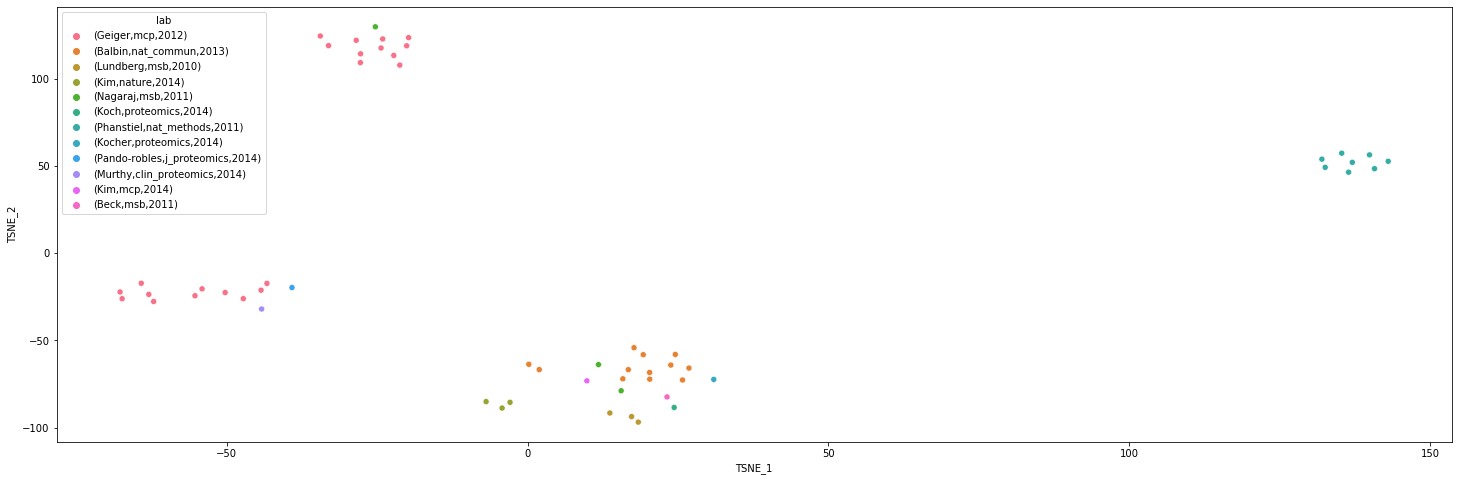

In [16]:
from matplotlib import pyplot as plt
plt.figure(figsize=(25,8))

sns.scatterplot(data=finalDF, x='TSNE_1', y='TSNE_2', hue='lab')

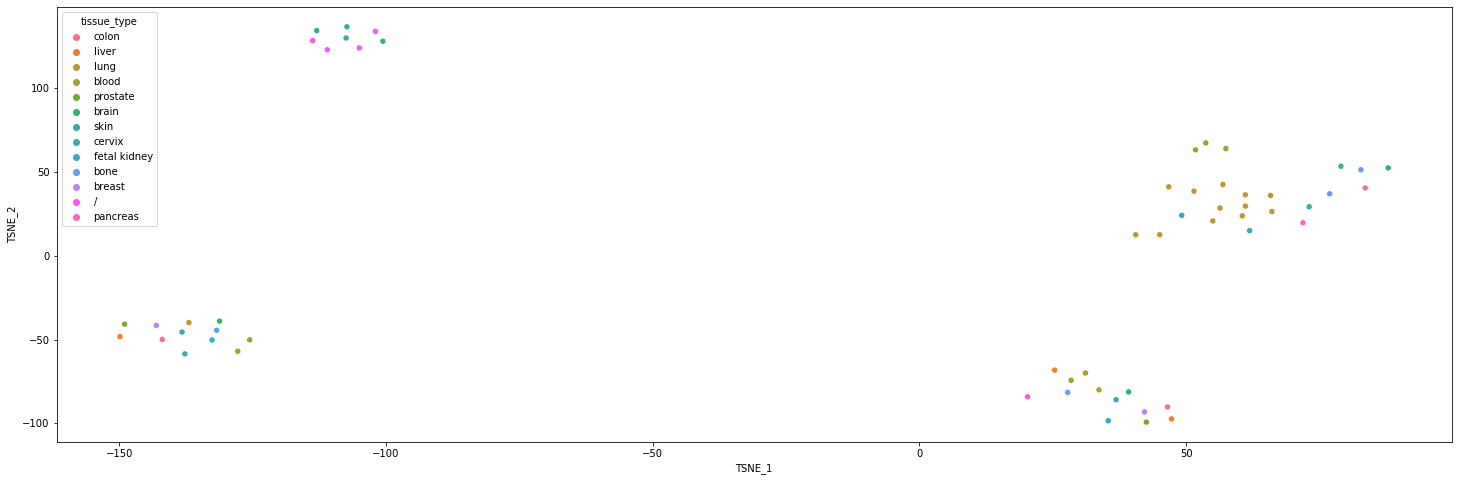

In [47]:
plt.figure(figsize=(25,8))

sns.scatterplot(data=finalDF, x='TSNE_1', y='TSNE_2', hue='tissue_type')

In [ ]:
plt.figure(figsize=(25,8))
sns.scatterplot(data=finalDF, x='TSNE_1', y='TSNE_2', hue='lab')

In [17]:
import umap.umap_ as umap
mapper = umap.UMAP()
mapper.fit(scaled)
umap_results=mapper.transform(scaled)
#umap_results = mapper.fit_transform(values)
principalDf = pd.DataFrame(data = umap_results, columns = ['TSNE_1', 'TSNE_2'])
    
finalDF_umap = pd.concat([principalDf, meta], axis = 1)

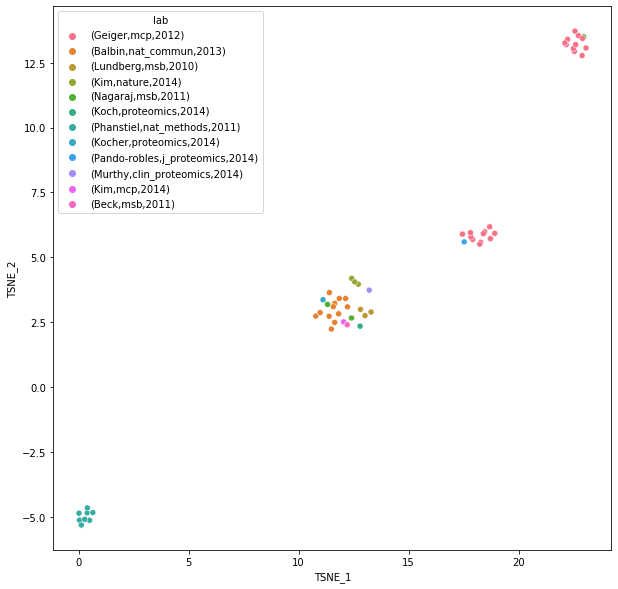

In [18]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=finalDF_umap, x='TSNE_1', y='TSNE_2', hue='lab', legend=True)

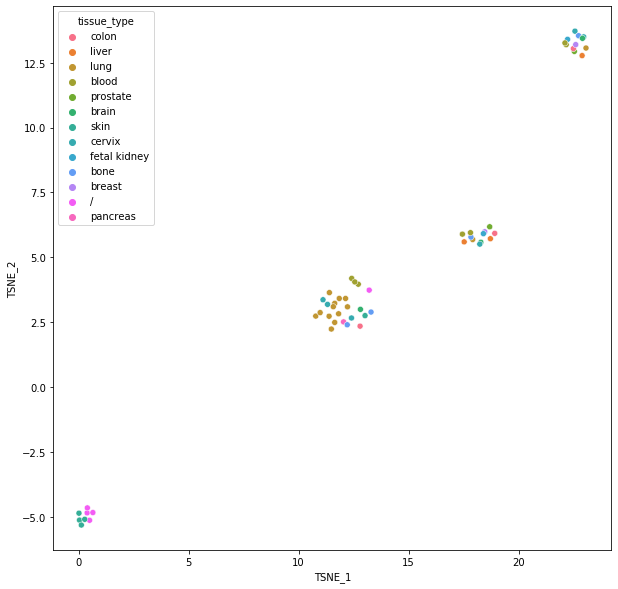

In [23]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=finalDF_umap, x='TSNE_1', y='TSNE_2', hue='tissue_type', legend=True)